# Primeros pasos

En este primer notebook se explica como cargar las librerías oportunas, verificar que la configuración es la adecuada y como llevar a cabo un caso de uso sencillo con un dataset típico

## Importar librerías
En primer lugar deben cargarse las librerías que permiten trabajar de una manera elegante y sencilla con técnicas de aprendizaje computacional. Para los primeros pasos se van a cargar las siguientes librerías:

**1. numpy**

Una librería de cálculo numérico que facilita el trabajar con matrices y vectores. Permite trabajar de una manera elegante con la espacialidad de los datos además de ofrecer funciones de cálculo para operaciones frecuentes (norma de un vector, determinante y rango de una matriz, ajuste polinómico, etc.).

**2. matplotlib**

Posiblemente la librería más popular para trabajar con gráficos en python, especialmente gráficos 2D de diversa índole y gráficos 3D estáticos no muy pesados. Existen librerías más potentes para trabajar en 3D, pero matplotlib ofrece un buen compromiso entre facilidad de uso y calidad del resultado. Además, es una librería muy usada y está bastante depurada.

**3. tensorflow + keras**

Esta combinación de librerías constituye el núcleo de trabajo con redes neuronales que se va a utilizar.

In [1]:
# Importar numpy con el nombre np (es una forma abreviada, para facilitar las invocaciones a la librería)
import numpy as np
# Importar la interfaz funcional de gráficos de matplotlib con el nombre plt (también abreviado por comodidad)
import matplotlib.pyplot as plt
# Importar keras desde tensorflow
import tensorflow.keras as keras
# Importar utilidades matemáticas de tensorflow
import tensorflow.math as tfmath

In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/s

## Verificar que Keras trabaja con la GPU
Para obtener un buen rendimiento al trabajar con redes neuronales, es importante aprovechar las ventajas computacionales de trabajar con GPU. Debe comprobarse que Keras trabaja realmente contra la GPU. Como Keras utiliza en el fondo tensorflow, basta con verificar que tensorflow se encuentra debidamente conectado con la GPU.

Si se está reconociendo debidamente la GPU debería verse una entrada en el registro de dispositivos indicándolo.

Por ejemplo:
```
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10505857280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4018314920207030387
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
```

O también:
```
name: "/gpu:0"
device_type: "GPU"
memory_limit: 215154688
locality {
  bus_id: 1
}
incarnation: 15042970723321838406
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0"
```

In [2]:
# Mostrar la lista de dispositivos reconocidos por tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 358573471290374763
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10565797824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7829607483453514399
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Cargar data set de prueba
A continuación, se procede a cargar el dataset MNIST (Modified National Institute of Standards and Technology). Se trata de un conjunto de datos que corresponden con imágenes de número escritos a mano.

En la variable `trainX` se tendrán los datos de entrenamiento (en este caso imágenes), en `trainY` las clases o etiquetas (labels) correspondientes a los datos de entrenamiento. Análogamente, se dispone de un conjunto de validación con datos en `testX` y clases o etiquetas de validación en `testY`

Una vez cargados los datos, se utiliza matplotlib para mostrar la primera imagen del conjunto de entrenamiento

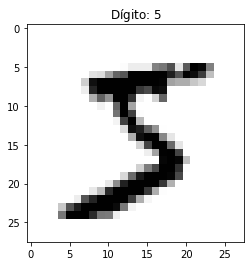

In [3]:
# Cargar data set
(trainX, trainY), (testX, testY) = keras.datasets.mnist.load_data()

# Generar un gráfico con una imagen de entrenamiento
idx = 0  # Indice del dato que se quiere imprimir (0 sería el primero)
plt.imshow(  # Generar un gráfico representando la matriz como una imagen
    trainX[idx],  # La representacion matricial de la imagen
    cmap='binary'  # El mapa de color
)  
plt.title('Dígito: ${l}$'.format(l=trainY[idx]))  # Añadir un título indicando el dígito
plt.show()  # Mostrar el gráfico construido

## Preparación de datos

Una clave fundamental para el buen funcionamiento de una red neuronal es garantizar que los datos de entrada sean adecuados.

En primer lugar debe verificarse el tipo de datos. A partir de la exploración inicial deben llevarse a cabo las transformaciones necesarias para normalizar adecuadamente los datos. Cabe mencionar que se pueden seguir estrategias de normalización directas como la normalización mínimo-máximo, técnicas estadísticas como estandarización o distintos métodos.

Para el caso concreto aquí tratado se sigue una estrategia de normalización mínimo-máximo (min-max normalization). Sea $X$ el conjunto de matrices de entrada donde cada elemento está definido en el mismo intervalo y sea $x^*$ el valor máximo de entre todos los valores del conjunto de matrices $X$, puede obtenerse la matrix $X^{'}$ como la versión normalizada de $X$. Así, $X^{'} = \left\{X^{'}_{1}, \ldots, X^{'}_{l}\right\}$ donde:

$
\forall i ,\, X^{'}_{i} =
\left[\begin{array}{ccc}
    \frac{x_{i11}}{x^*} & \ldots & \frac{x_{i1n}}{x^*} \\
    \vdots & \ddots & \vdots \\
    \frac{x_{im1}}{x^*} & \ldots & \frac{x_{imn}}{x^*}
\end{array}\right]
$

Nótese que lo anterior se cumple porque el canal de blanco a negro no tiene valores negativos. En caso de tener que normalizar un conjunto de valores que contenga negativos, debería usarse $\frac{x_{ijk}-min(X)}{max(X)-min(X)}$

Las principales ventajas de normalizar los datos es que se tiene una mayor estabilidad numérica en los cálculos y se consigue por un lado que la red neuronal converja más rápido y por el otro que sea más precisa.

Tipo numérico de los datos:  uint8
Datos: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 18 18 18 126 136 175 26 166 255 247 127 0 0 0 0]
 [0 0 0 0 0 0 0 0 30 36 94 154 170 253 253 253 253 253 225 172 253 242 195 64 0 0 0 0]
 [0 0 0 0 0 0 0 49 238 253 253 253 253 253 253 253 253 251 93 82 82 56 39 0 0 0 0 0]
 [0 0 0 0 0 0 0 18 219 253 253 253 253 253 198 182 247 241 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 80 156 107 253 253 205 11 0 43 154 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 14 1 154 253 90 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 139 253 190 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 11 190 253 70 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 35 241 225 160 108 1 0 0 0 0 0 0 0 0 

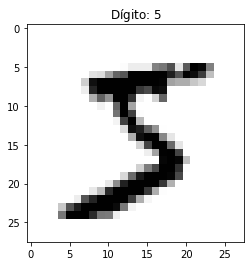

In [4]:
# Comprobar el tipo de los datos
print('Tipo numérico de los datos: ', trainX.dtype)

# Inspeccionar la estructura de datos para el primer caso
np.set_printoptions(linewidth=90, formatter={'all': lambda x: '{0}'.format(x)})
print('Datos: \n',trainX[0])

# Aplicar una normalización min-max
xmax = np.max(trainX)  # Hallar el valor máximo
trainX = trainX / xmax  # Dividir cada valor entre el máximo

# Comprobar el tipo de datos tras la normalización
print('Nuevo tipo numérico de los datos: ', trainX.dtype)

# Inspeccionar la estructura de los datos normalizados para el primer caso
np.set_printoptions(precision=4)
print('Datos normalizados: \n', trainX[0])

# Mostrar el gráfico que corresponde con una imagen
# De esta manera se verifica que, pese a la normalización, la imagen se mantiene
plt.imshow(  # Generar un gráfico representando la matriz como una imagen
    trainX[idx],  # La representacion matricial de la imagen
    cmap='binary'  # El mapa de color
)  
plt.title('Dígito: ${l}$'.format(l=trainY[idx]))  # Añadir un título indicando el dígito
plt.show()  # Mostrar el gráfico construido

## Más preparación de datos

Además de preparar los datos que el modelo de inteligencia artificial usa como entrada, también es necesario tratar adecuadamente la salida esperada de manera que esté en el formato adecuado. En el caso del dataset MNIST, una estrategia simple y adecuada es aplicar one-hot-encoding, de manera que se crea un atributo para cada dígito. Habiendo 10 dígitos (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), basta con hacer 10 categorías distintas. De esta manera cuando el dígito sea un 0 se asignará un 1 a tal categoría y un 0 a las demás, tal que $(1, 0, 0, 0, 0, 0, 0, 0, 0, 0)$. Si el número fuese, por ejemplo, un 7, se tendría el siguiente vector $(0, 0, 0, 0, 0, 0, 0, 1, 0, 0)$.

In [5]:
# Mostrar como es el ground truth originalmente
print('Ground truth base:\n', trainY)

# Aplicar one-hot-encoding al ground truth del conjunto de datos de entrenamiento
trainY = keras.utils.to_categorical(trainY, 10)

# Mostrar como queda el ground truth tras transformarlo
print('Ground truth tras one-hot-encoding:\n', trainY)

Ground truth base:
 [5 0 4 ... 5 6 8]
Ground truth tras one-hot-encoding:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## Terminando de preparar los datos

Finalmente, conviene no olvidar que toda la preparación de datos que se ha aplicado al conjunto de datos de entrenamiento, debe aplciarse también al conjunto de datos de validación. Para esto pueden seguirse distintas estrategias. Por ejemplo, pueden prepararse todos los datos y posteriormente separarlos en entrenamiento y validación. En este caso, simplemente se aplican las mismas operaciones que ya se han aplicado a `trainX` y `trainY` a los datos en `testX` y `testY`.

In [6]:
testX = testX / xmax  # Dividir cada valor entre el máximo
testY = keras.utils.to_categorical(testY, 10)  # One-hot-encoding

## Red neuronal básica (entrenamiento)

Como primer tipo de red neuronal se usará una red neuronal clásica también conocida como Feed Forward Neural Network. Se trata de un tipo de red compuesta por capas densas que opera con un único flujo: Desde la entrada hasta la salida. Se trata del tipo de red neuronal operativa más sencilla, además de presentar el elemento fundamental que se encuentra en las distintas variantes o arquitecturas de red neuronal, la capa densa.

En primer lugar, se debe construir un modelo que tenga como primera capa una capa de entrada (**Input Layer**). Esta capa se caracteriza por tener un tamaño coincidente con el tamaño de entrada esperado.

A continuación, se añaden un par de capas intermedias (**Hidden Layers**) con capas de Dropout entre ellas, que finalmente se pasarán a una capa de aplanamiento (Flatten). Las capas de Dropout apagan y encienden neuronas de manera pseudoaleatoria en cada ciclo de entrenamiento. Así, se previene un fenómeno no deseado conocido como sobreajuste u **overfitting**. Una red que sobreajusta a los datos de entrenamiento no generaliza bien a otros datos, lo cual no suele ser deseable. En cuanto a la capa de Flatten, es necesaria para convertir el formato matricial a la salida final.

La función de activación que se usa para las capas intermedias en este caso es una $ReLU$ (Rectified Linear Unit). Existen distintas alternativas ($tanh$, sigmoide, ...). La principal ventaja de la $ReLU$ es que es muy rápida al tratarse de una función compuesta por dos rectas con pendiente distinta de cero (una de ellas casi cero). El motivo por el que se consideran pendientes distintas de cero es porque la derivada de una constante es cero, lo cual llevaría al entrenamiento a estancarse, ya que el ajuste es matemáticamente equivalente a un problema de optimización basado en derivadas encadenadas.

Para la capa de salida (**Output Layer**) se utilizará un función **softmax** que es de la forma:
$\left(
    \frac{e^{x_{1}}}{\sum_{i=1}^{n}{e^{x_{i}}}},
    \ldots,
    \frac{e^{x_{n}}}{\sum_{i=1}^{n}{e^{x_{i}}}}
\right)$
De esta manera se obtiene un vector de salida tal que su elemento con mayor valor corresponde a la clase a la que con mas fidelidad pertenece el caso clasificado.

Como se ha mencionado, una red neuronal puede entenderse como un problema de optimización que trabaja con una **función de pérdida** $\mathcal{L}$. Según el tipo de problema, debe elegirse la función de pérdida adecuada. En el caso que se está desarrollando, se tiene un problema de clasificación multicategoría, por tanto se elige la entropía cruzada categórica como función de pérdida. Para realizar la optimización se elige un optimizador **adam** y como métrica de evaluación se toma la **accuracy** que responde a la fórmula que sigue:
$
Acc = \frac{TP + TN}{TP + TN + FP + FN}
$
Donde $TP$ son los True Positives, $TN$ los True Negatives, $FP$ los False Positives y $FN$ los False Negatives.

Por último, para entrenar el modelo, hay dos parámetros especialmente importantes:
1. *batch_size* El tamaño de lote. Los datos serán agrupados para ser digeridos en lotes de tantos elementos como los indicados.
2. *epochs* Las épocas de entrenamiento. Cuantas más épocas de entrenamiento, más veces se recorrera el conjunto de datos. Concretamente se recorre el conjunto de entrenamiento tantas veces como épocas. Un número muy reducido de épocas supone que la red apenas aprende, un número excesivo de épocas puede llevar a overfitting o simplemente a un desperdicio de recursos, ya que hay un límite a partir del cual no se saca provecho.

In [7]:
# Inicializar modelo
model = keras.models.Sequential()

# Añadir capa de entrada (Input Layer)
model.add(keras.layers.Input(trainX[0].shape))

# Añadir capas intermedias (Hidden Layers)
model.add(keras.layers.Dense(32, activation='relu'))  # Dense de 32 neuronas con ReLU
model.add(keras.layers.Dropout(0.1))  # Dropout del 10%
model.add(keras.layers.Dense(32, activation='relu'))  # Otra Dense de 32 neuronas con ReLU
model.add(keras.layers.Dropout(0.1))  # Otra Dropout del 10%

# Añadir aplanamiento antes de la salida
model.add(keras.layers.Flatten())

# Añadir capa de salida (Output Layer)
model.add(keras.layers.Dense(10, activation='softmax'))

# Mostrar un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28, 32)            928       
_________________________________________________________________
dropout (Dropout)            (None, 28, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 28, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8970      
Total params: 10,954
Trainable params: 10,954
Non-trainable params: 0
____________________________________________________

In [8]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Entrenar la red neuronal
n_epochs=8
history = model.fit(
    trainX,  # Datos de entrenamiento
    trainY,  # Clases de entrenamiento (Ground truth)
    batch_size=64,  # Tamaño de lote
    epochs=n_epochs,  # Épocas de entrenamiento
    verbose=1,  # Reportar el entrenamiento conforme se realiza
    validation_data=(testX, testY)  # Datos y clases para validar el entrenamiento
)

Epoch 1/8
938/938 [==============================] - 8s 5ms/step - loss: 0.7682 - accuracy: 0.7742 - val_loss: 0.2031 - val_accuracy: 0.9412
Epoch 2/8
938/938 [==============================] - 3s 4ms/step - loss: 0.2174 - accuracy: 0.9356 - val_loss: 0.1502 - val_accuracy: 0.9553
Epoch 3/8
938/938 [==============================] - 3s 4ms/step - loss: 0.1706 - accuracy: 0.9499 - val_loss: 0.1311 - val_accuracy: 0.9615
Epoch 4/8
938/938 [==============================] - 4s 4ms/step - loss: 0.1507 - accuracy: 0.9543 - val_loss: 0.1252 - val_accuracy: 0.9625
Epoch 5/8
938/938 [==============================] - 3s 4ms/step - loss: 0.1372 - accuracy: 0.9595 - val_loss: 0.1219 - val_accuracy: 0.9642
Epoch 6/8
938/938 [==============================] - 3s 4ms/step - loss: 0.1281 - accuracy: 0.9619 - val_loss: 0.1172 - val_accuracy: 0.9655
Epoch 7/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1276 - accuracy: 0.9617 - val_loss: 0.1181 - val_accuracy: 0.9652
Epoch 8/8
938

## Red neuronal básica (evaluación)

Al disponerse de un conjunto de datos de validación, puede evaluarse la red neuronal. Para ello se elaborarán un par de gráficos. En el mundo del análisis de datos es bastante importante la visualización de los datos, así que es recomendable acostumbrarse a distintas técnicas de representación ya que son la mejor guía para construir y refinar modelos.

El primero será un gráfico que permita analizar la **evolución de la función de pérdida y de la accuracy** para el conjunto de datos de entrenamiento y el de validación a lo largo de las distintas épocas. Su principal utilidad es analizar a partir de que punto deja de merecer la pena continuar entrenando. Además, da una primera impresión sobre como de bueno es el modelo teniendo en cuenta como se comporta la accuracy (o el conjunto de métricas que se haya elegido para evaluar).

El segundo será la representación visual de una **matriz de confusión** que muestre la calidad de la clasificación considerando las diferentes categorías. La matriz de confusión ideal es una matriz donde todos los elementos son nulos excepto en la diagonal, pues quiere decir que se ha clasificado perfectamente cada categoría. De aquí se sigue que, cuanto más concentrados estén los valores en la diagonal de la matriz de confusión, mejor será la clasificación. No obstante, se debe tomar con precaución una matriz de confusión perfecta o casi perfecta, pues podría ser síntoma de overfitting. En este caso la matriz de confusión tendrá *por columnas las clases predichas* y *por filas las clases esperadas*. Evidentemente, sería válido trabajar con la versión traspuesta de la matriz. Decídase el formato al gusto.

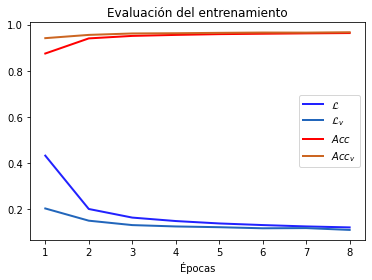

In [9]:
# Gráfico de pérdida y accuracy
T = np.arange(1, n_epochs+1, 1)
plt.plot(T, history.history['loss'], label='$\mathcal{L}$', color='#2222FF', lw=2)
plt.plot(T, history.history['val_loss'], label='$\mathcal{L}_{v}$', color='#2266BB', lw=2)
plt.plot(T, history.history['accuracy'], label='$Acc$', color='#FF0000', lw=2)
plt.plot(T, history.history['val_accuracy'], label='$Acc_{v}$', color='#CC6622', lw=2)
plt.title('Evaluación del entrenamiento')
plt.xlabel('Épocas')
plt.legend(loc='best')
plt.show()

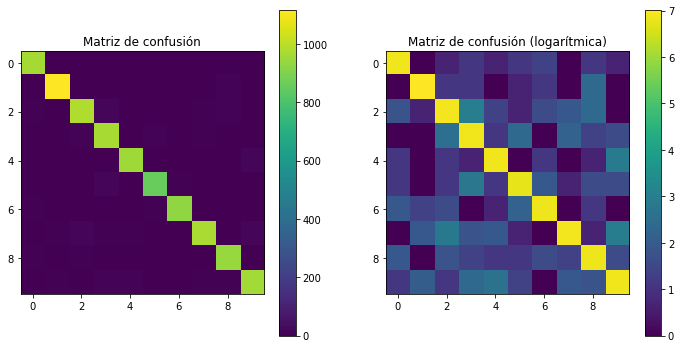

In [10]:
# Obtener la clasificación del modelo con respecto de los datos de validación
expe = testY.argmax(axis=1)  # Argmax para tomar el mayor valor como la clase real
pred = model.predict(testX).argmax(axis=1)  # Argmax para tomar el mayor valor tras aplicar softmax

# Obtener la matriz de confusión
cm = tfmath.confusion_matrix(expe, pred)

# Representación gráfica de la matriz de confusión
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)  # Gráfico izquierdo
mat1 = ax1.imshow(cm)
fig.colorbar(mat1, ax=ax1)
ax1.set_title('Matriz de confusión')

# Representación gráfica de la matriz de confusión en escala logarítmica
ax2 = fig.add_subplot(1, 2, 2)  # Gráfico derecho
mat2 = ax2.imshow(np.log(cm+1))
fig.colorbar(mat2, ax=ax2)
ax2.set_title('Matriz de confusión (logarítmica)')

# Mostrar gráficos
plt.show()

## Red neuronal convolucional

Ahora que se conoce la red neuronal clásica, puede entenderse la red neuronal convolucional (Convolutional Neural Network, CNN). Para ello es preciso añadir dos nuevos conceptos.

#### Pooling

La técnica de pooling requiere en primer lugar que se defina el tipo de operación que se utilizará para transformar un conjunto de datos en otro, generalmente de distinta dimensionalidad. Ejemplos de funciones de pooling podrían ser la función $max$ que toma el máximo valor de un conjunto, la función $min$ que toma el mínimo valor de un conjunto, el promedio, la mediana o cualquier función que se estime oportuna.

Puede entenderse esto de manera sencilla con un ejemplo. Sea la matriz
$
A =
\left[\begin{array}{ccc}
1 & 2 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0
\end{array}\right]
$
. En caso de aplicar max-pooling a la misma en una ventana $2 \times 2$ con un paso de $1$ daría lugar a una matrix $A'$ resultado de seleccionar un elemento con la función $max$ a cada submatriz.
$A' =
\left[\begin{array}{cc}
2 & 2 \\
1 & 1
\end{array}\right]
$

Nótese que el pooling no está restringido a matrices (2D) sino que puede aplicarse también en otras dimensiones, por ejemplo con vectores (1D) o cubos (3D).

#### Convolución
La función más habitual de las convoluciones en el contexto de las redes neuronales que trabajan con imágenes es codificar píxeles vecinos de manera que se obtenga una representación más compacta de los datos que facilita su procesamiento. Cabe mencionar que también existen procesos de expansión de datos, pero es un tema que no se tratará en este cuaderno.

Así, en la capa densa de una red neuronal, cada entrada se conecta con una salida. Por el contrario, en una capa convolucional, múltiples entradas se conectan a la misma salida. De ahí que se facilite la computación de los datos.

Las convoluciones, de manera semejante al pooling, se definen por un tamaño de ventana y un paso. La ventana se desliza por la estructura de datos. En el caso de las imágenes, por la matriz de píxeles. Supóngase la matriz
$
A =
\left[ \begin{array}{ccc}
    a_{11} & a_{12} & a_{13} \\ 
    a_{21} & a_{22} & a_{23} \\ 
    a_{31} & a_{32} & a_{33}
\end{array} \right]
$. Con una ventana de tamano $2 \times 2$ y un paso de $1$. Se tendrían las siguientes 4 convoluciones:

$
A_{1} = \left[\begin{array}{cc}
    a_{11} & a_{12} \\
    a_{21} & a_{22}
\end{array}\right]
$
$
A_{2} = \left[\begin{array}{cc}
    a_{12} & a_{13} \\
    a_{22} & a_{23}
\end{array}\right]
$
$
A_{3} = \left[\begin{array}{cc}
    a_{21} & a_{22} \\
    a_{31} & a_{32}
\end{array}\right]
$
$
A_{4} = \left[\begin{array}{cc}
    a_{22} & a_{23} \\
    a_{32} & a_{33}
\end{array}\right]
$

Por tanto, se estarían conectando 4 bloques de 4 elementos a 4 neuronas. Si no se convolucionase, se tendrían 9 bloques de 1 elemento cada uno conectado a una neurona, lo que daría un total de 9 neuronas. Resulta sencillo entender que, en consecuencia, al convolucionar de esta manera se simplifican las computaciones. Además, al encontrarse los datos estructurados, se aprovecha la información espacial de los mismos, analizándolos en función de distintas vecindadades (distintos tamaños de ventana y distintos pasos).

In [11]:
# Aumentar la dimensionalidad de las matrices para considerar el color (canal blanco-negro en este caso)
trainXconv = np.expand_dims(trainX, -1)
testXconv = np.expand_dims(testX, -1)

# Componer modelo
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(  # Capa convolucional 2D
    32,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    input_shape=trainXconv[0].shape
))
model.add(keras.layers.Conv2D(  # Otra capa convolucional 2D
    64,
    kernel_size=(3, 3),
    activation='relu'
))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling
model.add(keras.layers.Dropout(0.25)) # Dropout para prevenir overfitting
model.add(keras.layers.Flatten())  # Aplanar la matriz
model.add(keras.layers.Dense(128, activation='relu'))  # Capa densa (clásica) intermedia
model.add(keras.layers.Dropout(0.5)) # Otra capa de dropout
model.add(keras.layers.Dense(10, activation='softmax'))  # Capa densa (clásica) de salida

# Mostrar un resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [12]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Entrenar la red neuronal
n_epochs=8
history = model.fit(
    trainXconv,  # Datos de entrenamiento
    trainY,  # Clases de entrenamiento (Ground truth)
    batch_size=64,  # Tamaño de lote
    epochs=n_epochs,  # Épocas de entrenamiento
    verbose=1,  # Reportar el entrenamiento conforme se realiza
    validation_data=(testXconv, testY)  # Datos y clases para validar el entrenamiento
)

Epoch 1/8
938/938 [==============================] - 16s 5ms/step - loss: 0.4340 - accuracy: 0.8647 - val_loss: 0.0489 - val_accuracy: 0.9838
Epoch 2/8
938/938 [==============================] - 4s 4ms/step - loss: 0.0857 - accuracy: 0.9753 - val_loss: 0.0353 - val_accuracy: 0.9875
Epoch 3/8
938/938 [==============================] - 5s 5ms/step - loss: 0.0639 - accuracy: 0.9808 - val_loss: 0.0306 - val_accuracy: 0.9902
Epoch 4/8
938/938 [==============================] - 5s 5ms/step - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.0326 - val_accuracy: 0.9899
Epoch 5/8
938/938 [==============================] - 5s 5ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0289 - val_accuracy: 0.9894
Epoch 6/8
938/938 [==============================] - 5s 5ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0318 - val_accuracy: 0.9898
Epoch 7/8
938/938 [==============================] - 5s 5ms/step - loss: 0.0332 - accuracy: 0.9892 - val_loss: 0.0267 - val_accuracy: 0.9916
Epoch 8/8
93

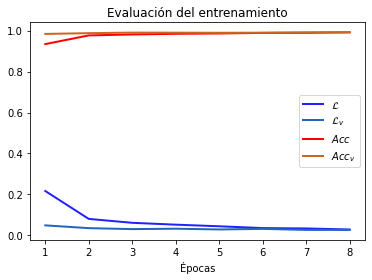

In [13]:
# Gráfico de pérdida y accuracy
T = np.arange(1, n_epochs+1, 1)
plt.plot(T, history.history['loss'], label='$\mathcal{L}$', color='#2222FF', lw=2)
plt.plot(T, history.history['val_loss'], label='$\mathcal{L}_{v}$', color='#2266BB', lw=2)
plt.plot(T, history.history['accuracy'], label='$Acc$', color='#FF0000', lw=2)
plt.plot(T, history.history['val_accuracy'], label='$Acc_{v}$', color='#CC6622', lw=2)
plt.title('Evaluación del entrenamiento')
plt.xlabel('Épocas')
plt.legend(loc='best')
plt.show()

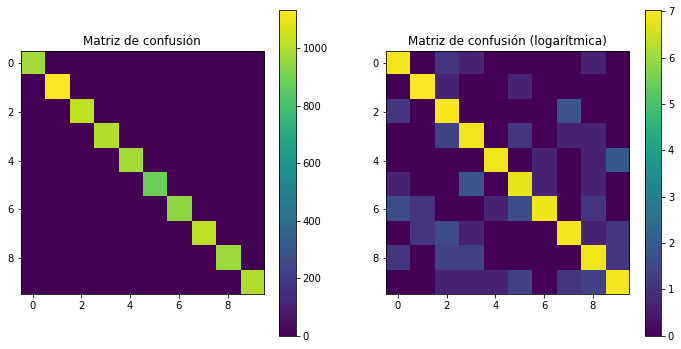

In [14]:
# Obtener la clasificación del modelo con respecto de los datos de validación
expe = testY.argmax(axis=1)  # Argmax para tomar el mayor valor como la clase real
pred = model.predict(testXconv).argmax(axis=1)  # Argmax para tomar el mayor valor tras aplicar softmax

# Obtener la matriz de confusión
cm = tfmath.confusion_matrix(expe, pred)

# Representación gráfica de la matriz de confusión
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)  # Gráfico izquierdo
mat1 = ax1.imshow(cm)
fig.colorbar(mat1, ax=ax1)
ax1.set_title('Matriz de confusión')

# Representación gráfica de la matriz de confusión en escala logarítmica
ax2 = fig.add_subplot(1, 2, 2)  # Gráfico derecho
mat2 = ax2.imshow(np.log(cm+1))
fig.colorbar(mat2, ax=ax2)
ax2.set_title('Matriz de confusión (logarítmica)')

# Mostrar gráficos
plt.show()

## Red neuronal convolucional profunda

Para terminar, se construirá una versión profunda de la red neuronal convolucional. ¿Qué significa que una red sea profunda? No hay una definición formal universal de las condiciones necesarias que debe cumplir una arquitectura profunda. Para evitar entrar en una discusión bizantina, tomemos por idea general que hablar de una red neuronal profunda implica utilizar una abundante cantidad de capas intermedias. Como no hay un criterio universalmente aceptado para determinar a partir de qué número de capas se debe considerar una arquitectura como profunda, simplemente añadiremos más capas a la anterior red convolucional y consideraremos que es profunda en comparación.

Suele entenderse implícitamente que una red profunda tiene una mayor capacidad de aprendizaje. Sin embargo, es un error colegir que a mayor número de capas mejor red. Cuando se trabaja con aprendizaje computacional debe revisarse la calidad de los resultados en función de las métricas que más nos interesen (precision, recall, F1 score, residuos cuadrados, AUC/ROC, etc). Además, añadir arbitrariamente capas sin ningún criterio, podría ser una estrategia válida como punto de partida, pero continuar añadiendo capas ad infinitum no garantiza obtener un mejor resultado, mucho menos acercarse a la solución óptima. Conviene no olvidar que más capas supone mayor complejidad de entrenamiento y, en consecuencia, mayor consumo de recursos (infraestructura computacional, electricidad, etc.).

Tómese por tanto este ejemplo como un caso trivial para ilustrar como construir una arquitectura más grande de las que se han visto hasta ahora, no como una estrategia universalmente válida para cualquier problema que se trate con técnicas de aprendizaje computacional.

#### Estrategia particular

La estrategia que se seguirá para el caso que aquí se cubre será la de construir 3 bloques convolucionales, cada cual con mayor dimensionalidad de salida, y un bloque final clásico. Cada bloque intermedio constará de capas convolucionales y una operación final de max-pooling (una estrategia clásica en procesamiento de imágenes con CNN). El número de salida de cada bloque es mayor respecto del anterior. Esto se debe a que tras cada bloque se reduce la dimensionalidad de los datos, de manera que se puede aumentar el tamaño de las capas densas que los procesan. Puede entenderse este procesamiento como examinar con un microscopio una muestra, de manera que en cada capa se aumenta más el zoom. 

Por otro lado, se utilizan algunos nuevos parámetros:

**1. padding** Tal y como se configuran las convoluciones se reduce la dimensionalidad de la imagen. El padding consiste en añadir un relleno compuesto de ceros para cubrir los huecos. 

**2. stride** Aunque ya se ha mencionado antes el paso, en este caso se configura explícitamente a través de este parámetro.

**3. name** Al tener una arquitectura más grande, es buena idea poner un nombre a las capas para poder reconocer bien en el resumen la red y verificar que su estructura es la deseada.

In [15]:
# Inicializar modelo
model = keras.models.Sequential()

# Añadir capa de entrada (Input Layer)
model.add(keras.layers.Input(trainXconv[0].shape))

# ---  Bloque 1  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 1
    64,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque1_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Segunda capa convolucional del bloque 1
    64,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque1_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(  # Max-pooling del bloque 1
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(2, 2),  # Configuración del paso
    name='bloque1_maxpooling'  # Nombre de la capa
))


# ---  Bloque 2  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 2
    128,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque2_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Segunda capa convolucional del bloque 2
    128,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque2_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(  # Max-pooling del bloque 2
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(2, 2),  # Configuración del paso
    name='bloque2_maxpooling'  # Nombre de la capa
))


# ---  Bloque 3  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 3
    256,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Segunda capa convolucional del bloque 3
    256,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Tercera capa convolucional del bloque 3
    256,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    activation='relu',  # Función de activación
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_convolucion3'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(  # Max-pooling del bloque 3
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(2, 2),  # Configuración del paso
    name='bloque3_maxpooling'  # Nombre de la capa
))


# ---  Bloque clásico  --- #
# ------------------------ #
model.add(keras.layers.Flatten())  # Capa de aplanamiento
model.add(keras.layers.Dense(512, activation='relu', name='FF1'))  # Capa densa clásica
model.add(keras.layers.Dense(512, activation='relu', name='FF2'))  # Capa densa clásica
model.add(keras.layers.Dense(10, activation='softmax', name='Predicciones'))  # Capa densa clásica de salida



# Mostrar un resumen del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bloque1_convolucion1 (Conv2D (None, 28, 28, 64)        640       
_________________________________________________________________
bloque1_convolucion2 (Conv2D (None, 28, 28, 64)        36928     
_________________________________________________________________
bloque1_maxpooling (MaxPooli (None, 14, 14, 64)        0         
_________________________________________________________________
bloque2_convolucion1 (Conv2D (None, 14, 14, 128)       73856     
_________________________________________________________________
bloque2_convolucion2 (Conv2D (None, 14, 14, 128)       147584    
_________________________________________________________________
bloque2_maxpooling (MaxPooli (None, 7, 7, 128)         0         
_________________________________________________________________
bloque3_convolucion1 (Conv2D (None, 7, 7, 256)        

In [16]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Entrenar la red neuronal profunda
n_epochs=8
history = model.fit(
    trainXconv,  # Datos de entrenamiento
    trainY,  # Clases de entrenamiento (Ground truth)
    batch_size=64,  # Tamaño de lote
    epochs=n_epochs,  # Épocas de entrenamiento
    verbose=1,  # Reportar el entrenamiento conforme se realiza
    validation_data=(testXconv, testY)  # Datos y clases para validar el entrenamiento
)

Epoch 1/8
938/938 [==============================] - 11s 11ms/step - loss: 0.4287 - accuracy: 0.8563 - val_loss: 0.0486 - val_accuracy: 0.9846
Epoch 2/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0520 - accuracy: 0.9844 - val_loss: 0.0362 - val_accuracy: 0.9900
Epoch 3/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0416 - accuracy: 0.9882 - val_loss: 0.0271 - val_accuracy: 0.9923
Epoch 4/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0378 - val_accuracy: 0.9890
Epoch 5/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0266 - val_accuracy: 0.9930
Epoch 6/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.0591 - val_accuracy: 0.9881
Epoch 7/8
938/938 [==============================] - 10s 10ms/step - loss: 0.0233 - accuracy: 0.9939 - val_loss: 0.0569 - val_accuracy: 0.9858

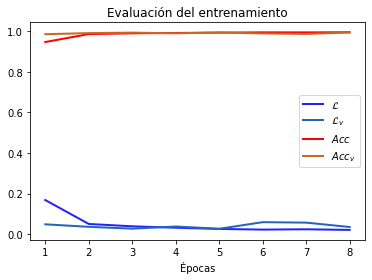

In [17]:
# Gráfico de pérdida y accuracy
T = np.arange(1, n_epochs+1, 1)
plt.plot(T, history.history['loss'], label='$\mathcal{L}$', color='#2222FF', lw=2)
plt.plot(T, history.history['val_loss'], label='$\mathcal{L}_{v}$', color='#2266BB', lw=2)
plt.plot(T, history.history['accuracy'], label='$Acc$', color='#FF0000', lw=2)
plt.plot(T, history.history['val_accuracy'], label='$Acc_{v}$', color='#CC6622', lw=2)
plt.title('Evaluación del entrenamiento')
plt.xlabel('Épocas')
plt.legend(loc='best')
plt.show()

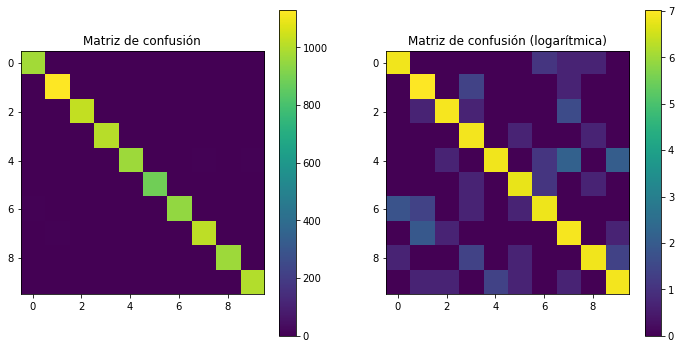

In [18]:
# Obtener la clasificación del modelo con respecto de los datos de validación
expe = testY.argmax(axis=1)  # Argmax para tomar el mayor valor como la clase real
pred = model.predict(testXconv).argmax(axis=1)  # Argmax para tomar el mayor valor tras aplicar softmax

# Obtener la matriz de confusión
cm = tfmath.confusion_matrix(expe, pred)

# Representación gráfica de la matriz de confusión
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)  # Gráfico izquierdo
mat1 = ax1.imshow(cm)
fig.colorbar(mat1, ax=ax1)
ax1.set_title('Matriz de confusión')

# Representación gráfica de la matriz de confusión en escala logarítmica
ax2 = fig.add_subplot(1, 2, 2)  # Gráfico derecho
mat2 = ax2.imshow(np.log(cm+1))
fig.colorbar(mat2, ax=ax2)
ax2.set_title('Matriz de confusión (logarítmica)')

# Mostrar gráficos
plt.show()